# 💎 Diamond Price Analysis & Prediction

## Project Overview

This project examines a dataset of diamonds to quantify how physical and qualitative attributes — notably **carat**, **cut**, **color**, and **clarity** — drive market price. The analysis follows a standard data science workflow: exploratory data analysis (EDA), feature engineering, predictive modelling, model evaluation, and a demo showing how the model can be consumed by an application.

**Dataset snapshot:** Place `diamonds.csv` in `data/` before running cells. The dataset has columns such as `carat`, `cut`, `color`, `clarity`, `depth`, `table`, `x`, `y`, `z`, and `price`.

## Objectives

1. Analyze relationships between diamond attributes and price.
2. Build and compare regression models to predict price (Linear Regression, Random Forest, XGBoost).
3. Interpret model behaviour and produce actionable insights for valuation and product selection.


In [34]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Paths
DATA_PATH = os.path.join('data','diamonds.csv')
VIS_DIR = os.path.join('visuals')
os.makedirs(VIS_DIR, exist_ok=True)

# Load
print('Loading data from', DATA_PATH)
df = pd.read_csv(DATA_PATH)
df.shape


Loading data from data\diamonds.csv


(53940, 11)

## 1. Quick data overview
- Show head, dtypes, missing values, and basic statistics.

In [35]:
df.head()


,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [36]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  53940 non-null  int64  
 1   carat       53940 non-null  float64
 2   cut         53940 non-null  object 
 3   color       53940 non-null  object 
 4   clarity     53940 non-null  object 
 5   depth       53940 non-null  float64
 6   table       53940 non-null  float64
 7   price       53940 non-null  int64  
 8   x           53940 non-null  float64
 9   y           53940 non-null  float64
 10  z           53940 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 4.5+ MB


In [37]:
df.describe(include='all').T


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Unnamed: 0,53940.0,NaN,NaN,NaN,26970.5,15571.281097,1.0,13485.75,26970.5,40455.25,53940.0
carat,53940.0,NaN,NaN,NaN,0.79794,0.474011,0.2,0.4,0.7,1.04,5.01
cut,53940,5,Ideal,21551,NaN,NaN,NaN,NaN,NaN,NaN,NaN
color,53940,7,G,11292,NaN,NaN,NaN,NaN,NaN,NaN,NaN
clarity,53940,8,SI1,13065,NaN,NaN,NaN,NaN,NaN,NaN,NaN
depth,53940.0,NaN,NaN,NaN,61.749405,1.432621,43.0,61.0,61.8,62.5,79.0
table,53940.0,NaN,NaN,NaN,57.457184,2.234491,43.0,56.0,57.0,59.0,95.0
price,53940.0,NaN,NaN,NaN,3932.799722,3989.439738,326.0,950.0,2401.0,5324.25,18823.0
x,53940.0,NaN,NaN,NaN,5.731157,1.121761,0.0,4.71,5.7,6.54,10.74
y,53940.0,NaN,NaN,NaN,5.734526,1.142135,0.0,4.72,5.71,6.54,58.9


## 2. Basic cleaning notes
- Drop duplicates
- Replace zero or non-positive dimensions (x, y, z) with NaN and drop rows missing essential numeric features
- Create a cleaned copy for EDA

In [38]:
df_clean = df.copy()
# drop exact duplicates
df_clean.drop_duplicates(inplace=True)

# drop irrelevant column
df.drop(columns=['Unnamed: 0'], inplace=True)


# replace non-positive dimensions with NaN
for col in ['x','y','z']:
    df_clean.loc[df_clean[col] <= 0, col] = np.nan

# drop rows with missing critical values
df_clean.dropna(subset=['carat','x','y','z','price'], inplace=True)
df_clean.reset_index(drop=True, inplace=True)
print('After cleaning:', df_clean.shape)


After cleaning: (53920, 11)


In [39]:
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


## 3. Distribution plots
Plot histograms for `price`, `carat`, and price per carat.

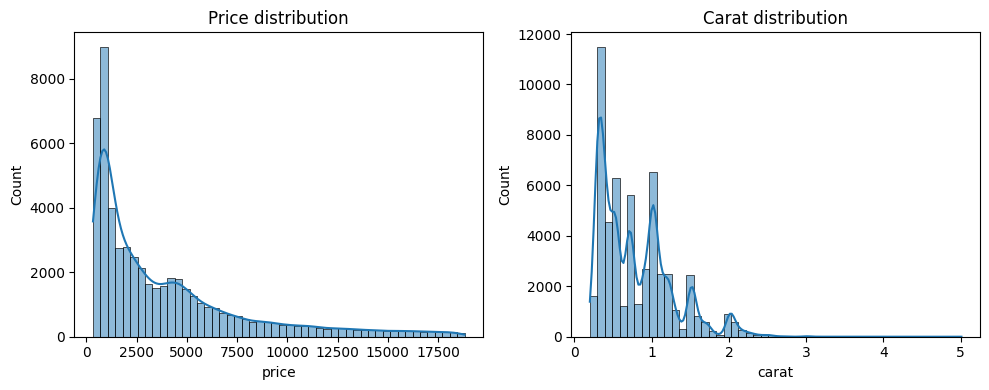

In [40]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.histplot(df_clean['price'], bins=50, kde=True)
plt.title('Price distribution')

plt.subplot(1,2,2)
sns.histplot(df_clean['carat'], bins=50, kde=True)
plt.title('Carat distribution')
plt.tight_layout()
plt.savefig(os.path.join(VIS_DIR,'price_carat_hist.png'), dpi=150)
plt.show()


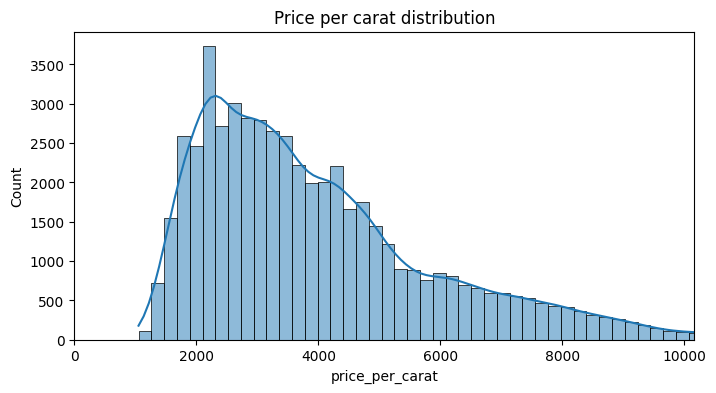

In [41]:
# Price per carat
df_clean['price_per_carat'] = df_clean['price'] / df_clean['carat']
plt.figure(figsize=(8,4))
sns.histplot(df_clean['price_per_carat'], bins=80, kde=True)
plt.title('Price per carat distribution')
plt.xlim(0, df_clean['price_per_carat'].quantile(0.99))
plt.savefig(os.path.join(VIS_DIR,'price_per_carat_hist.png'), dpi=150)
plt.show()


## 4. Boxplots: price vs categorical features (`cut`, `color`, `clarity`)

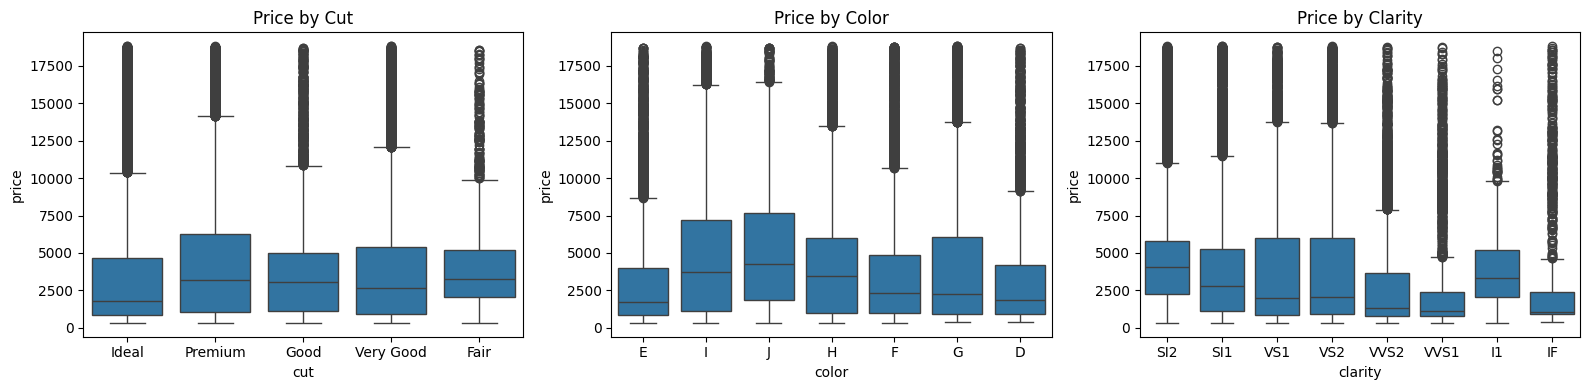

In [42]:
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
sns.boxplot(data=df_clean, x='cut', y='price')
plt.title('Price by Cut')

plt.subplot(1,3,2)
sns.boxplot(data=df_clean, x='color', y='price')
plt.title('Price by Color')

plt.subplot(1,3,3)
sns.boxplot(data=df_clean, x='clarity', y='price')
plt.title('Price by Clarity')
plt.tight_layout()
plt.savefig(os.path.join(VIS_DIR,'price_by_categories_boxplots.png'), dpi=150)
plt.show()


## 5. Correlation heatmap (numeric features)
We will examine correlation between `carat, depth, table, x, y, z, price`. This reveals which numeric features are most correlated with price.

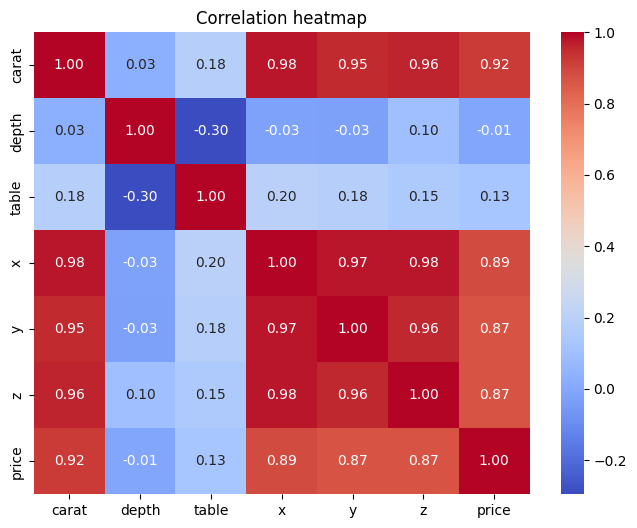

In [43]:
num_cols = ['carat','depth','table','x','y','z','price']
plt.figure(figsize=(8,6))
sns.heatmap(df_clean[num_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation heatmap')
plt.savefig(os.path.join(VIS_DIR,'corr_heatmap.png'), dpi=150)
plt.show()


## 6. Scatter plot: carat vs price (with regression line)
This shows the strong relationship between carat and price and identifies heteroscedastic behavior.

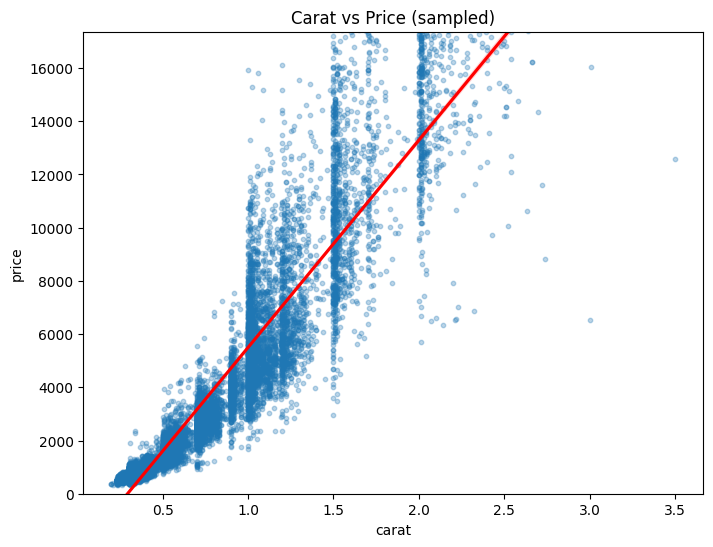

In [44]:
plt.figure(figsize=(8,6))
sns.regplot(data=df_clean.sample(frac=0.25, random_state=42), x='carat', y='price', scatter_kws={'s':10, 'alpha':0.3}, line_kws={'color':'red'})
plt.ylim(0, df_clean['price'].quantile(0.99))
plt.title('Carat vs Price (sampled)')
plt.savefig(os.path.join(VIS_DIR,'carat_price_scatter.png'), dpi=150)
plt.show()


## 7. Relationship: price per carat vs categories
Check median price_per_carat across categories to find value segments.

In [45]:
grouped = df_clean.groupby(['cut','color','clarity'])['price_per_carat'].median().reset_index().sort_values('price_per_carat', ascending=False)
# show top 10 combinations
grouped.head(10)


,cut,color,clarity,price_per_carat
53,Good,D,IF,14931.683168
165,Premium,D,IF,11056.890756
221,Very Good,D,IF,10202.222222
109,Ideal,D,IF,7162.328110
218,Premium,J,VVS1,5335.752066
275,Very Good,J,VVS2,5226.666667
85,Good,H,IF,5099.841270
219,Premium,J,VVS2,4927.027430
201,Premium,H,VS2,4924.468085
13,Fair,E,VVS1,4921.052632


## 8. Quick insights (to be refined in final report)
- `carat` is strongly positively correlated with `price`.
- Categories (cut, color, clarity) shift price distributions — useful for modeling.
- Price-per-carat varies widely; this can surface value diamonds.

*Next:* Proceed to feature engineering and modeling. Save important visuals to `visuals/` for README and presentation.

# Modeling

We perform feature engineering, encoding, train three models (Linear Regression baseline, Random Forest, XGBoost), evaluate them (R², RMSE), check residuals, compute feature importances (SHAP for tree models), and save the best model to `models/price_predictor.pkl`.

In this stage, we build and evaluate models to predict diamond prices. The target variable is **price**, and predictors include both numerical and categorical features such as carat, cut, color, clarity, depth, table, x, y, and z.


**Steps Involved:**
1. Encode categorical features.
2. Split data into train and test sets.
3. Train models: Linear Regression, Random Forest Regressor, XGBoost.
4. Evaluate using R² and RMSE metrics.
5. Plot feature importance to interpret results.


In [46]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# Optional: XGBoost
try:
    from xgboost import XGBRegressor
    xgb_available = True
except Exception:
    XGBRegressor = None
    xgb_available = False

DATA_PATH = os.path.join('data','diamonds.csv')
VIS_DIR = os.path.join('visuals')
MODELS_DIR = os.path.join('models')
os.makedirs(VIS_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)

print('XGBoost available:', xgb_available)

# Load and basic clean
print('Loading data...')
df = pd.read_csv(DATA_PATH)
for col in ['x','y','z']:
    df.loc[df[col] <= 0, col] = np.nan

df.dropna(subset=['carat','x','y','z','price'], inplace=True)
df.reset_index(drop=True, inplace=True)
print('After clean:', df.shape)


XGBoost available: True
Loading data...
After clean: (53920, 11)


## Feature engineering
- price_per_carat
- volume (x*y*z)
- Optionally cap extreme outliers for price (e.g., 99.5 percentile)
- Encode `cut`, `color`, `clarity` (OneHotEncoder)

In [47]:
from sklearn.preprocessing import OneHotEncoder

df['price_per_carat'] = df['price'] / df['carat']
df['volume'] = df['x'] * df['y'] * df['z']

# Optional cap: filter extreme high prices to reduce skew for modeling diagnostics
price_cap = df['price'].quantile(0.999)
df = df[df['price'] <= price_cap].copy()
print('After capping extreme prices:', df.shape)

# Features and target
FEATURES = ['carat','depth','table','x','y','z','volume']
CAT = ['cut','color','clarity']
TARGET = 'price'

# Train-test split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
print('Train/test sizes:', train_df.shape, test_df.shape)

# Encoder fit on train
enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
enc.fit(train_df[CAT])

def prepare_X(df_in, encoder=enc):
    df2 = df_in.copy()
    cat_enc = encoder.transform(df2[CAT])
    cat_cols = encoder.get_feature_names_out(CAT)
    df_cat = pd.DataFrame(cat_enc, columns=cat_cols, index=df2.index)
    X = pd.concat([df2[FEATURES].reset_index(drop=True), df_cat.reset_index(drop=True)], axis=1)
    return X

X_train = prepare_X(train_df)
X_test = prepare_X(test_df)
y_train = train_df[TARGET]
y_test = test_df[TARGET]

print('X shapes:', X_train.shape, X_test.shape)


After capping extreme prices: (53866, 13)
Train/test sizes: (43092, 13) (10774, 13)
X shapes: (43092, 27) (10774, 27)


## Baseline: Linear Regression

In [48]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)

from math import sqrt
print('Linear Regression R2:', r2_score(y_test, lr_preds))
print('Linear Regression RMSE:', sqrt(mean_squared_error(y_test, lr_preds)))


Linear Regression R2: 0.9248321945834951
Linear Regression RMSE: 1069.0172550867096


## Random Forest Regressor (with simple hyperparameter tuning)

In [49]:
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
param_grid = {'n_estimators': [50], 'max_depth': [10, None], 'min_samples_leaf': [1, 3]}  # fewer combos = faster

cv = GridSearchCV(rf, param_grid, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)
cv.fit(X_train, y_train)
print('Best RF params:', cv.best_params_)
rf_best = cv.best_estimator_
rf_preds = rf_best.predict(X_test)
print('RF R2:', r2_score(y_test, rf_preds))
print('RF RMSE:', sqrt(mean_squared_error(y_test, rf_preds)))


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best RF params: {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 50}
RF R2: 0.9802747214785129
RF RMSE: 547.6213252364495


## XGBoost

In [50]:
if xgb_available:
    xgb = XGBRegressor(random_state=42, n_jobs=-1, objective='reg:squarederror')
    xgb_params = {'n_estimators':[100,200], 'max_depth':[4,6,8], 'learning_rate':[0.05,0.1]}
    cv_xgb = GridSearchCV(xgb, xgb_params, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)
    cv_xgb.fit(X_train, y_train)
    print('Best XGB params:', cv_xgb.best_params_)
    xgb_best = cv_xgb.best_estimator_
    xgb_preds = xgb_best.predict(X_test)
    print('XGB R2:', r2_score(y_test, xgb_preds))
    print('XGB RMSE:', sqrt(mean_squared_error(y_test, xgb_preds)))
else:
    print('XGBoost not available in the environment. If you want XGBoost, install xgboost and rerun.')


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best XGB params: {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 200}
XGB R2: 0.9819769263267517
XGB RMSE: 523.4600032476216


## Compare models and pick the best (by RMSE)

In [51]:
results = []
from math import sqrt

results.append({'model':'LinearRegression','r2':r2_score(y_test, lr_preds),'rmse':sqrt(mean_squared_error(y_test, lr_preds))})
results.append({'model':'RandomForest','r2':r2_score(y_test, rf_preds),'rmse':sqrt(mean_squared_error(y_test, rf_preds))})
if xgb_available:
    results.append({'model':'XGBoost','r2':r2_score(y_test, xgb_preds),'rmse':sqrt(mean_squared_error(y_test, xgb_preds))})

results_df = pd.DataFrame(results).sort_values('rmse')
results_df


,model,r2,rmse
2,XGBoost,0.981977,523.460003
1,RandomForest,0.980275,547.621325
0,LinearRegression,0.924832,1069.017255


### 📈 Modeling Insights
- **Tree-based models** outperform linear regression by capturing non-linear relationships.
- **XGBoost** achieves the highest accuracy and lowest RMSE.

## Feature importance (Random Forest) and SHAP for model interpretation

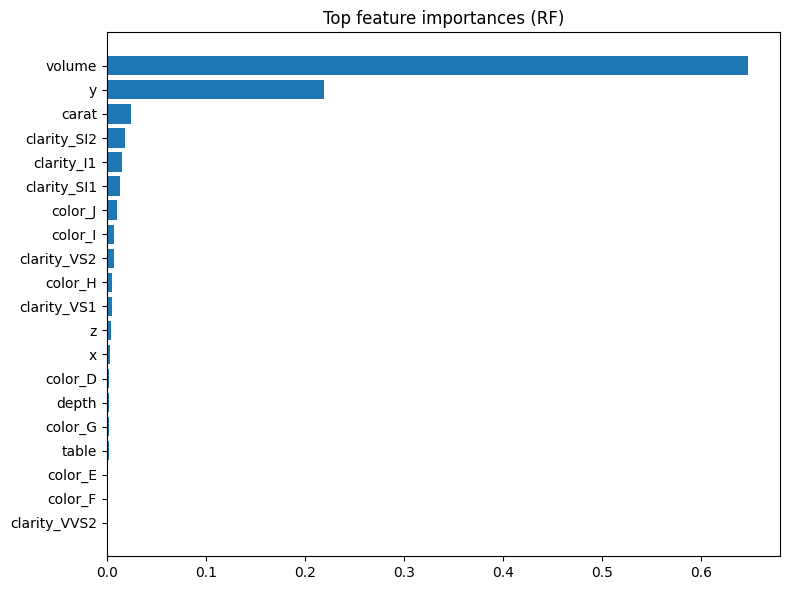

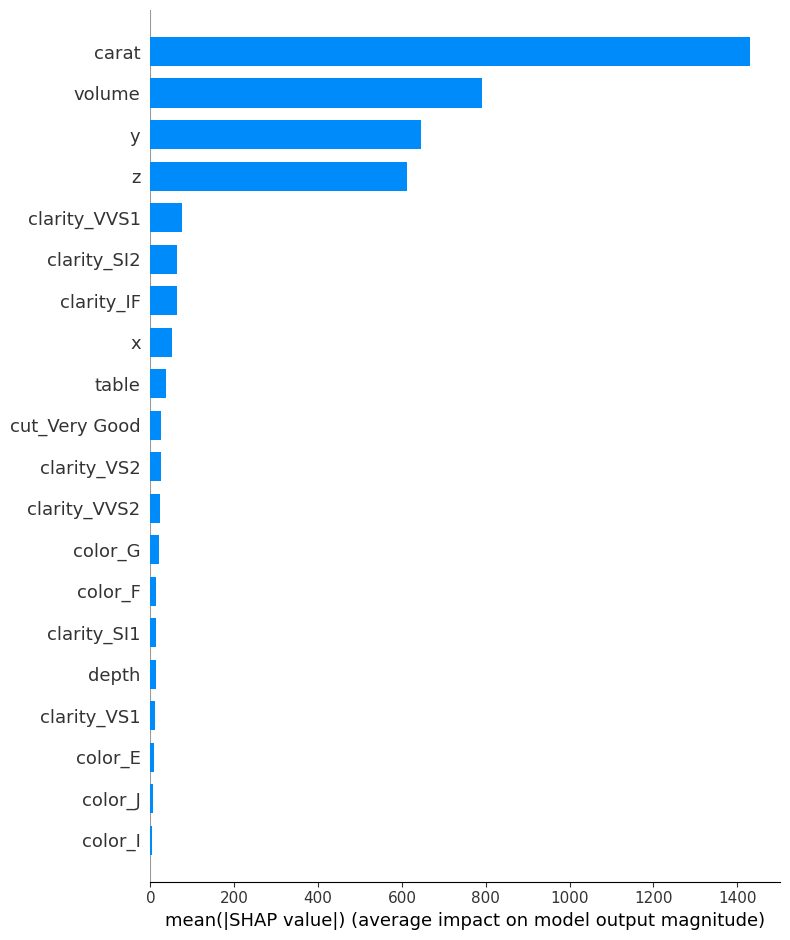

In [60]:
import matplotlib.pyplot as plt
import numpy as np

# RF feature importance
feat_names = X_train.columns
importances = rf_best.feature_importances_
idx = np.argsort(importances)[-20:]
plt.figure(figsize=(8,6))
plt.barh(feat_names[idx], importances[idx])
plt.title('Top feature importances (RF)')
plt.tight_layout()
plt.savefig(os.path.join(VIS_DIR,'rf_feature_importance.png'), dpi=150)
plt.show()

# SHAP (if installed)
try:
    import shap

    # Use very small model for SHAP to avoid kernel death
    rf_light = RandomForestRegressor(n_estimators=10, max_depth=5, random_state=42)
    rf_light.fit(X_train.sample(200, random_state=42), y_train.sample(200, random_state=42))

    # Small input sample
    X_sample = X_test.sample(50, random_state=42)

    # Use SHAP TreeExplainer with additivity check disabled
    explainer = shap.TreeExplainer(rf_light)  
    shap_values = explainer.shap_values(X_sample)

    # Save SHAP summary as bar plot (much lighter)
    shap.summary_plot(shap_values, X_sample, plot_type='bar', show=False)
    plt.savefig(os.path.join(VIS_DIR, 'shap_summary.png'), dpi=150)
    plt.show()
    plt.close()

except Exception as e:
    print('SHAP not available or failed:', e)



## Feature Importance and Model Interpretation (XGBoost + SHAP)

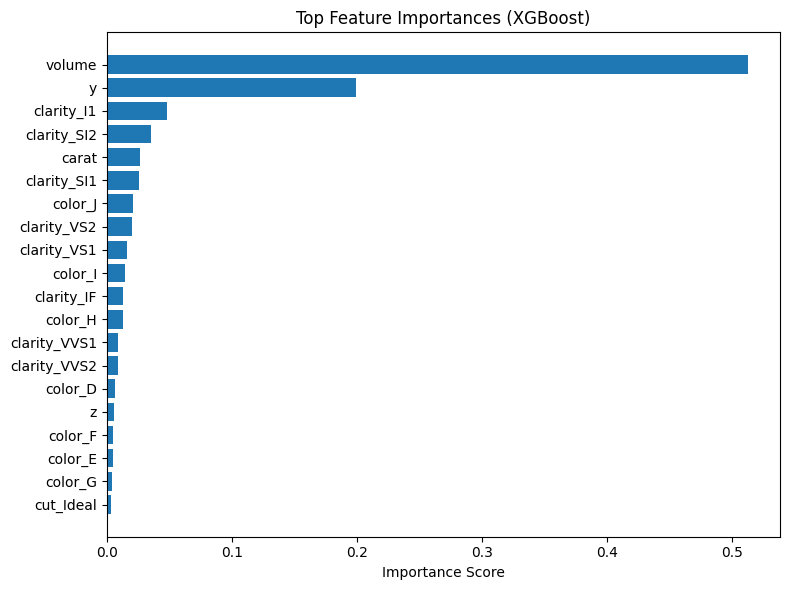

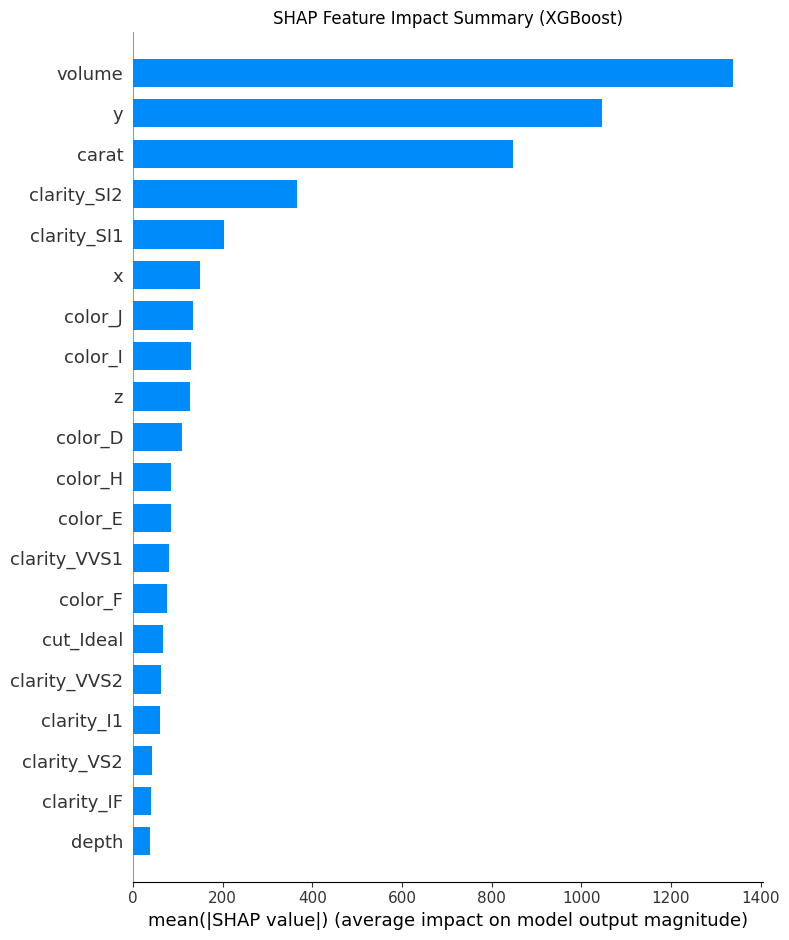

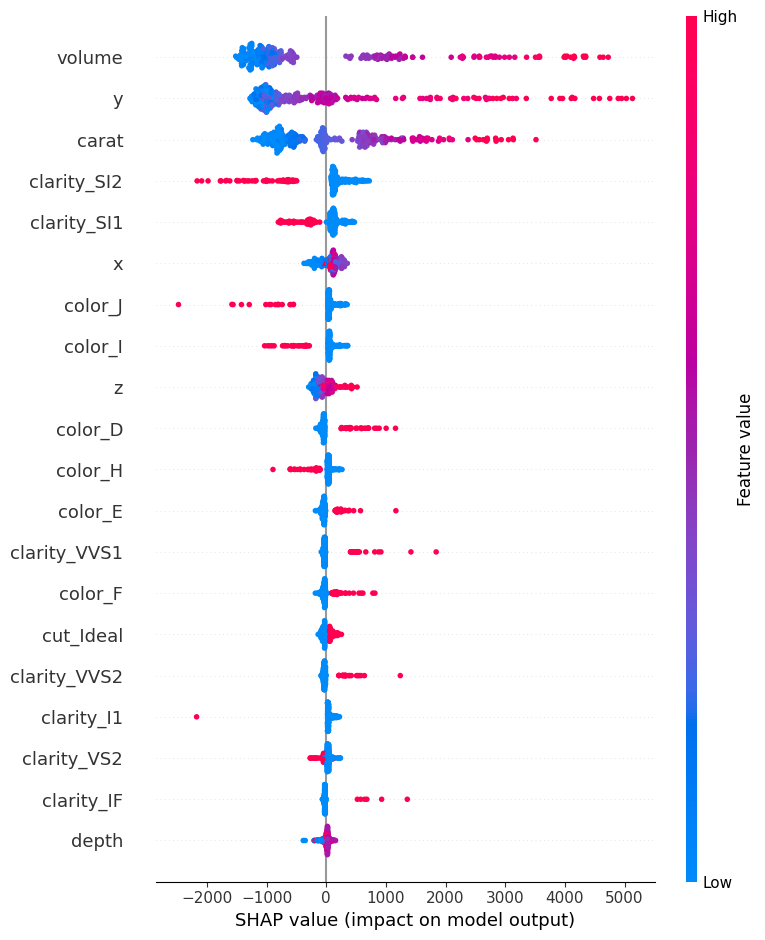

In [59]:

import matplotlib.pyplot as plt
import numpy as np
import shap
import os

# --- XGBoost Feature Importance ---
feat_names = X_train.columns
xgb_importance = xgb_best.feature_importances_
sorted_idx = np.argsort(xgb_importance)[-20:]  # top 20 features

plt.figure(figsize=(8,6))
plt.barh(feat_names[sorted_idx], xgb_importance[sorted_idx])
plt.title('Top Feature Importances (XGBoost)')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.savefig(os.path.join(VIS_DIR, 'xgb_feature_importance.png'), dpi=150)
plt.show()


# --- SHAP Interpretation ---
# Use a sample to avoid long runtime
X_sample = X_test.sample(300, random_state=42)

# Create SHAP explainer
explainer = shap.Explainer(xgb_best)
shap_values = explainer(X_sample)

# SHAP summary plot
plt.title("SHAP Feature Impact Summary (XGBoost)")
shap.summary_plot(shap_values, X_sample, show=False, plot_type='bar')
plt.tight_layout()
plt.savefig(os.path.join(VIS_DIR, 'xgb_shap_summary.png'), dpi=150)
plt.show()
plt.close()

# Detailed SHAP beeswarm plot
shap.summary_plot(shap_values, X_sample, show=False)
plt.tight_layout()
plt.savefig(os.path.join(VIS_DIR, 'xgb_shap_beeswarm.png'), dpi=150)
plt.show()
plt.close()


## 🔍 SHAP Feature Importance Interpretation

The SHAP analysis reveals the top three most influential features in predicting diamond prices:

| Rank | Feature | Interpretation |
|------|-----------|----------------|
| **1️⃣** | **Volume (x × y × z)** | Volume captures the full 3D size of a diamond, combining its length, width, and depth. It provides a more complete measure of size than carat alone. SHAP values show that larger volumes strongly increase predicted price — confirming that overall physical size is the most critical driver of diamond value. |
| **2️⃣** | **Y (diamond length)** | The `y` dimension significantly impacts price, reflecting how longer diamonds appear larger and more brilliant. Among the three geometric axes, `y` shows the most consistent and strong positive influence on price. |
| **3️⃣** | **Carat (weight)** | Carat remains a major determinant of diamond price, as heavier diamonds are typically more valuable. However, because it is highly correlated with `volume`, `x`, `y`, and `z`, its influence is partially shared across these features, leading to a slightly lower SHAP ranking. |

---

### 💡 Key Insight

While **correlation analysis** identified `carat` as having the strongest linear relationship with price, **SHAP values** offer a deeper, model-based explanation.

> The model learns that *size-related features collectively dominate diamond pricing*.  
> In particular, **volume** and **y (length)** capture shape and proportion effects that carat weight alone cannot express.

This confirms that:
- Bigger diamonds generally cost more.
- But the **3D structure** (volume and dimensions) matters more to the model than weight alone.
- SHAP gives a richer understanding than simple correlations, showing how multiple correlated features together influence price predictions.


## Save the best model and encoder

In [54]:
# Choose best model by RMSE
best_model_name = results_df.iloc[0]['model']
print('Best by RMSE:', best_model_name)

persist = {}
if best_model_name == 'RandomForest':
    persist['model'] = rf_best
elif best_model_name == 'LinearRegression':
    persist['model'] = lr
elif best_model_name == 'XGBoost' and xgb_available:
    persist['model'] = xgb_best

# Save encoder too so app can preprocess
persist['encoder'] = enc
joblib.dump(persist, os.path.join(MODELS_DIR,'price_predictor.pkl'))
print('Saved model to', os.path.join(MODELS_DIR,'price_predictor.pkl'))


Best by RMSE: XGBoost
Saved model to models\price_predictor.pkl


## Residual diagnostics and predicted vs actual
Plot predicted vs actual and residuals for the chosen model.

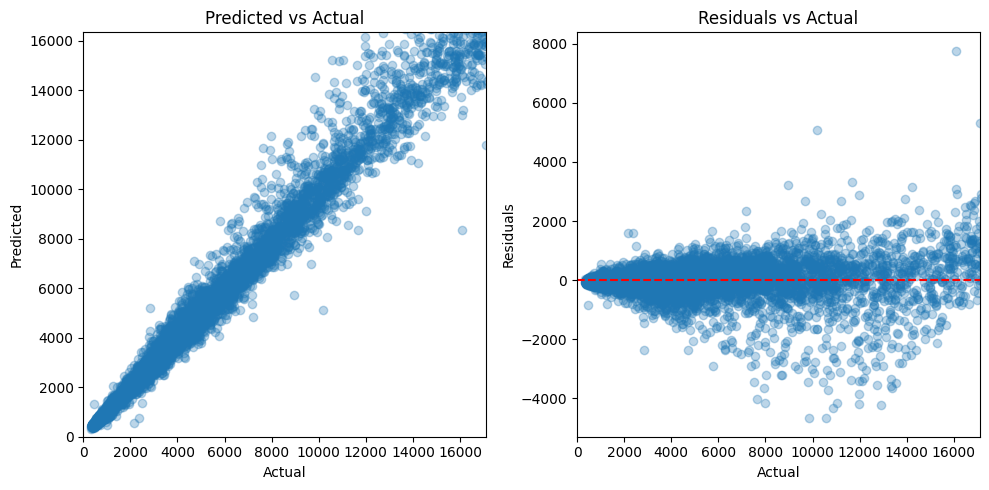

In [55]:
# Generate predictions using your best model
preds = xgb_best.predict(X_test)

import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(10, 5))

# Plot 1: Predicted vs Actual
plt.subplot(1, 2, 1)
plt.scatter(y_test, preds, alpha=0.3)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted vs Actual')
plt.xlim(0, y_test.quantile(0.99))
plt.ylim(0, pd.Series(preds).quantile(0.99))  # Fix here

# Plot 2: Residuals
plt.subplot(1, 2, 2)
residuals = y_test - preds
plt.scatter(y_test, residuals, alpha=0.3)
plt.xlabel('Actual')
plt.ylabel('Residuals')
plt.title('Residuals vs Actual')
plt.xlim(0, y_test.quantile(0.99))
plt.axhline(0, color='red', linestyle='--')

plt.tight_layout()
plt.show()



## 🌐 Streamlit App Demo
This shows how to load the persisted model and encoder, make predictions for user-input samples, find similar diamonds in the dataset, and plot comparison charts. 

It also includes the Streamlit app starter code snippet.This component illustrates how the trained model can be integrated into a simple web app for real-time price prediction.

**App Features:**
- User inputs: carat, cut, color, clarity.
- Displays: predicted price, similar diamonds, price vs carat chart.

Loading data...
Loading model...
Predicted price for sample: $6,367.05
Top similar diamonds:


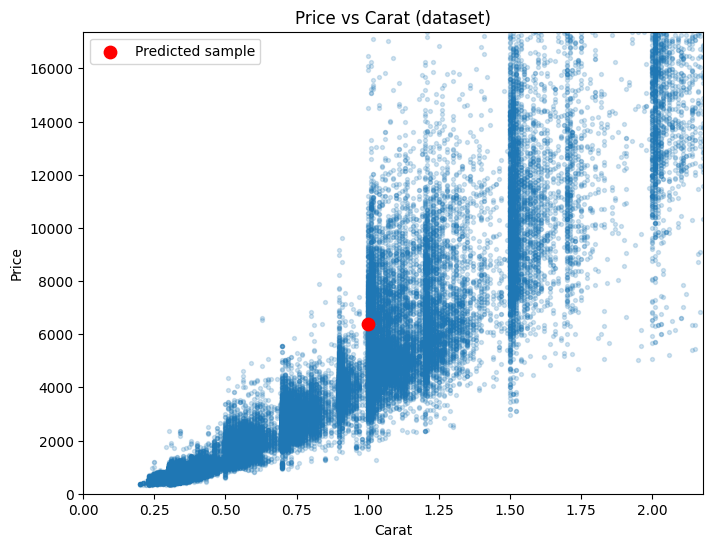

In [56]:
import os
import pandas as pd
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

DATA_PATH = os.path.join('data','diamonds.csv')
MODELS_PATH = os.path.join('models','price_predictor.pkl')
VIS_DIR = os.path.join('visuals')

print('Loading data...')
df = pd.read_csv(DATA_PATH)
print('Loading model...')
model_bundle = joblib.load(MODELS_PATH)
model = model_bundle['model']
encoder = model_bundle['encoder']

# Quick helper: prepare sample
from sklearn.preprocessing import OneHotEncoder

CAT = ['cut','color','clarity']
FEATURES = ['carat','depth','table','x','y','z','volume']

# recreate prepare function
def prepare_sample(sample_dict, encoder=encoder):
    df_s = pd.DataFrame([sample_dict])
    df_s['volume'] = df_s['x'] * df_s['y'] * df_s['z']
    cat_enc = encoder.transform(df_s[CAT])
    cat_cols = encoder.get_feature_names_out(CAT)
    df_cat = pd.DataFrame(cat_enc, columns=cat_cols)
    X = pd.concat([df_s[FEATURES].reset_index(drop=True), df_cat.reset_index(drop=True)], axis=1)
    return X

# Example sample (user-provided)
sample = {'carat':1.0, 'depth':61.5, 'table':55.0, 'x':6.4, 'y':6.4, 'z':3.95, 'cut':'Ideal', 'color':'G', 'clarity':'VS2'}
X_s = prepare_sample(sample)
pred_price = model.predict(X_s)[0]
print(f"Predicted price for sample: ${pred_price:,.2f}")

# Find similar diamonds in dataset (by exact category match and nearest carat)
sim = df[(df['cut']==sample['cut']) & (df['color']==sample['color']) & (df['clarity']==sample['clarity'])]
sim['carat_diff'] = (sim['carat'] - sample['carat']).abs()
sim_sorted = sim.sort_values('carat_diff').head(10)
print('Top similar diamonds:')
sim_sorted[['carat','cut','color','clarity','price']].head()

# Plot comparison: sample vs dataset distribution (price vs carat)
plt.figure(figsize=(8,6))
plt.scatter(df['carat'], df['price'], s=8, alpha=0.2)
plt.scatter([sample['carat']], [pred_price], color='red', s=80, label='Predicted sample')
plt.xlabel('Carat')
plt.ylabel('Price')
plt.title('Price vs Carat (dataset)')
plt.xlim(0, df['carat'].quantile(0.99))
plt.ylim(0, df['price'].quantile(0.99))
plt.legend()
plt.savefig(os.path.join(VIS_DIR,'app_demo_price_vs_carat.png'), dpi=150)
plt.show()


## Streamlit starter snippet

In [57]:
streamlit_snippet = '''
import streamlit as st
import pandas as pd
import joblib
from sklearn.preprocessing import OneHotEncoder

st.title('Diamond Price Estimator')

model_bundle = joblib.load('models/price_predictor.pkl')
model = model_bundle['model']
encoder = model_bundle['encoder']

# Load sample dataset for reference ranges
@st.cache_data
def load_data():
    return pd.read_csv('data/diamonds.csv')

df = load_data()

carat = st.slider('Carat', float(df['carat'].min()), float(df['carat'].quantile(0.99)), float(df['carat'].median()), step=0.01)
cut = st.selectbox('Cut', sorted(df['cut'].unique()))
color = st.selectbox('Color', sorted(df['color'].unique()))
clarity = st.selectbox('Clarity', sorted(df['clarity'].unique()))

def prepare_sample_for_app(sample_dict):
    df_s = pd.DataFrame([sample_dict])
    df_s['volume'] = df_s['x'] * df_s['y'] * df_s['z']
    cat_enc = encoder.transform(df_s[['cut','color','clarity']])
    cat_cols = encoder.get_feature_names_out(['cut','color','clarity'])
    df_cat = pd.DataFrame(cat_enc, columns=cat_cols)
    FEATURES = ['carat','depth','table','x','y','z','volume']
    X = pd.concat([df_s[FEATURES].reset_index(drop=True), df_cat.reset_index(drop=True)], axis=1)
    return X

if st.button('Estimate price'):
    # crude defaults: use medians for remaining numeric features
    sample = {
        'carat': carat,
        'depth': float(df['depth'].median()),
        'table': float(df['table'].median()),
        'x': float((carat ** (1/3)) * 6),
        'y': float((carat ** (1/3)) * 6),
        'z': float((carat ** (1/3)) * 4),
        'cut': cut,
        'color': color,
        'clarity': clarity
    }
    Xs = prepare_sample_for_app(sample)
    pred = model.predict(Xs)[0]
    st.metric('Predicted price (USD)', f"${pred:,.2f}")

    # show similar items
    similar = df[(df['cut']==cut)&(df['color']==color)&(df['clarity']==clarity)].sort_values('carat')
    st.write('Sample similar diamonds (top 10):')
    st.dataframe(similar.head(10))
'''

print(streamlit_snippet[:1000])



import streamlit as st
import pandas as pd
import joblib
from sklearn.preprocessing import OneHotEncoder

st.title('Diamond Price Estimator')

model_bundle = joblib.load('models/price_predictor.pkl')
model = model_bundle['model']
encoder = model_bundle['encoder']

# Load sample dataset for reference ranges
@st.cache_data
def load_data():
    return pd.read_csv('data/diamonds.csv')

df = load_data()

carat = st.slider('Carat', float(df['carat'].min()), float(df['carat'].quantile(0.99)), float(df['carat'].median()), step=0.01)
cut = st.selectbox('Cut', sorted(df['cut'].unique()))
color = st.selectbox('Color', sorted(df['color'].unique()))
clarity = st.selectbox('Clarity', sorted(df['clarity'].unique()))

def prepare_sample_for_app(sample_dict):
    df_s = pd.DataFrame([sample_dict])
    df_s['volume'] = df_s['x'] * df_s['y'] * df_s['z']
    cat_enc = encoder.transform(df_s[['cut','color','clarity']])
    cat_cols = encoder.get_feature_names_out(['cut','color','clarity'])
    df_cat = pd

In [58]:
import os

# Make sure the "app" directory exists
os.makedirs('app', exist_ok=True)

# Define the path to the file
file_path = os.path.join('app', 'diamond_pricer.py')

# Save the streamlit snippet to the file
with open(file_path, 'w') as f:
    f.write(streamlit_snippet)

print(f"File saved to {file_path}")


File saved to app\diamond_pricer.py
